# Demo de Algortimos de Regresión para generar fórmulas que permite estimar datos


In [ ]:
#@title Librerías a usar
import ipywidgets as widgets
from ipywidgets import Box, Layout
from IPython.display import clear_output

import os
import csv

from matplotlib import pyplot as plt
import pandas as pd
import numpy as np

from sklearn import linear_model
from sklearn.preprocessing import PolynomialFeatures

from sklearn.model_selection import train_test_split

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import math

print("Librerías cargadas")

Librerías cargadas


# Datos:

In [ ]:
#@title Acceder al Drive

# monta Google Drive:
# Nota: la primera vez se debe confirmar el uso logueandose en "Google Drive File Stream" y obteniendo código de autentificación.
from google.colab import drive
drive.mount('/content/gdrive')

# directorio local en Google Drive
path = '/content/gdrive/My Drive/IA/demoIA/datos/'  #@param {type:"string"}


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:

#@title Cargar datos


#@markdown ### Archivo de datos a utilizar:
archivo_datos = 'IRIS.csv'  #@param {type:"string"}
#@markdown ### Configuración del archivo CSV:
delimitador_columnas = ',' #@param {type:"string"}

## selección de los parámetros

# función para cargar configuración datos automática
def cargarNombreClases(path, archivo_datos):
  # importa definición de la clase
  arClasesFN = archivo_datos.split('.')[0] + '_nombreClases.txt'
  if os.path.isfile( path + '/' + arClasesFN ):
    with open( path + '/' + arClasesFN, mode='r') as csvfile:
        r = csv.reader(csvfile, delimiter=',')
        auxAtributo = r.__next__()
        auxClases = r.__next__()
    print('\n> Definición de los valores discretos para la clase cargada de ' + arClasesFN +'.\n')
    return auxAtributo[0], ','.join(auxClases)
  else:
    return "", ""

# función auxiliara para que no ejecute UI cada vez
def hacerNada():
  return

# se define esta función para que se ocupe de aplicar la configuración
def on_buttonAplicar_clicked(b):
  print("")
  funcionCambiaSeleccion_ConfigDatos(combo_att_clase.value, texto_nomClases.value, combo_att_entrada.value)

# aplica configuración de datos
def funcionCambiaSeleccion_ConfigDatos(attClase, nomClases, att_entrada):
  global Y, X, nombre_clases, atributos_entrada, ClassAttributeName

  if (attClase is None) or (attClase =="") or\
    (att_entrada is None) or (att_entrada ==""):
    return

  # si el atributo clase está como de entrada, lo saca (no tiene sentido)
  att_entrada = list(att_entrada)
  if attClase in att_entrada:
    print("Eliminando atributo " + attClase + " como de entrada dado que es clase.")
    att_entrada.remove( attClase )

  if (att_entrada == "") or (len(att_entrada)==0):
    print("No se han definido atributos de entrada!")
    return

  # guarda configuración
  nombre_clases = nomClases

    # genera los datos solo con los atributos seleccionados
  Y = np.array(df[attClase])
  X = np.array(df[att_entrada])

  # muestra resultados
  print("\n> Atributos entrada: ", att_entrada)
  print("\t X: ", X.shape)

  if (nombre_clases is None) or (nombre_clases==""):
    print("\n> Atributo clase: ", attClase)
  else:
    print("\n> Atributo clase: ", attClase, " [", nombre_clases, "]")
  print("\t Y: ", Y.shape)

  # guarda para usar luego
  atributos_entrada = att_entrada
  ClassAttributeName = attClase

## aplicación de los parámetros elegidos

# configura para que muestre todas las columnas y filas
pd.options.display.max_rows = 100
pd.options.display.max_columns = 100

# Carga los datos del CSV y muestra los primeros
df = pd.read_csv(path + archivo_datos,  sep=delimitador_columnas, engine="python")
print("Archivo de datos ", archivo_datos, " cargado")

print("\n> Cabecera: ")
print(df.head())
print("\n> Características: ")
print(df.describe())
print("\n")

# inicializa valores
X = None
Y = None
atributos_entrada = []
ClassAttributeName = ""

# intenta cargar configuración asociada a los datos
# trata de obtener la configuración del archivo asociado
atributo_clase, nombre_clases = cargarNombreClases(path, archivo_datos)

# muestra interface para cargar configuración

# auxiliar para que muestre bien la descripción
style_3D = {'description_width': 'initial'}

tit = widgets.Label("Ajuste para configuración de los Datos: ")

# prepara combo para determinar atributo clase
selecc_atributos = [ ]
selecc_atributos.extend( df.columns.values.tolist() )
if (atributo_clase is None) or (atributo_clase=="") or (atributo_clase not in selecc_atributos):
  att_selecc_defecto = len(selecc_atributos)-1
else:
  att_selecc_defecto = selecc_atributos.index(atributo_clase)
combo_att_clase = widgets.Dropdown(
    options = selecc_atributos,
    value = selecc_atributos[att_selecc_defecto], # mostrar por defecto de config
    description = 'Atributo clase:',
    style=style_3D,
    disabled = False,
)
# prepara campo para ingresar nombre clases (toma por defecto de config)
texto_nomClases = widgets.Text(
    value=nombre_clases,
    placeholder='Ingrese nombre clases (si corresponde) separados por comas',
    description='Nombre clases:',
    style=style_3D,
    disabled=False
)

combo_att_entrada = widgets.SelectMultiple(
    options=selecc_atributos,
    value=selecc_atributos,
    #rows=10,
    description='Atributos de entrada:',
    style=style_3D,
    disabled=False
)

# prepara botón y grilla con objetos
btnAplicar = widgets.Button(
    description='Aplicar'
)
configDatos_ui = widgets.GridBox(
      children=[tit, combo_att_clase, texto_nomClases, combo_att_entrada, btnAplicar],
      layout=Layout(width='100%')  )
btnAplicar.on_click(on_buttonAplicar_clicked)

#clear_output()
out_config = widgets.interactive_output(hacerNada, {})
display(configDatos_ui)

# ejecuta para que muestre
on_buttonAplicar_clicked(btnAplicar)


Archivo de datos  IRIS.csv  cargado

> Cabecera: 
   LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo  Clase
0          5.1          3.5          1.4          0.2      1
1          4.9          3.0          1.4          0.2      1
2          4.7          3.2          1.3          0.2      1
3          4.6          3.1          1.5          0.2      1
4          5.0          3.6          1.4          0.2      1

> Características: 
       LargoSepalo  AnchoSepalo  LargoPetalo  AnchoPetalo       Clase
count   150.000000   150.000000   150.000000   150.000000  150.000000
mean      5.843333     3.054000     3.758667     1.198667    2.000000
std       0.828066     0.433594     1.764420     0.763161    0.819232
min       4.300000     2.000000     1.000000     0.100000    1.000000
25%       5.100000     2.800000     1.600000     0.300000    1.000000
50%       5.800000     3.000000     4.350000     1.300000    2.000000
75%       6.400000     3.300000     5.100000     1.800000    3.000000
max

GridBox(children=(Label(value='Ajuste para configuración de los Datos: '), Dropdown(description='Atributo clas…


Eliminando atributo Clase como de entrada dado que es clase.

> Atributos entrada:  ['LargoSepalo', 'AnchoSepalo', 'LargoPetalo', 'AnchoPetalo']
	 X:  (150, 4)

> Atributo clase:  Clase  [ na,Setosa,Versicolor,Virginica ]
	 Y:  (150,)


In [ ]:
#@title Preparar datos

#@markdown Determina si el atributo clase debe ser considerado como Discreto o Continuo
considerar_atributo_clase = "continuo - ESTIMACION" #param ["discreto - CLASIFICACION", "continuo - ESTIMACION"]

#@markdown Porcentaje de datos para usar en el entrenamiento:
proporcion_porcentaje_datos_entrenamiento =   75#@param {type:"integer"}

# determina la proporción a usar para entrenar y probar
if proporcion_porcentaje_datos_entrenamiento>100:
  propTrain = 1
elif proporcion_porcentaje_datos_entrenamiento<1:
  propTrain = 0.1
else:
  propTrain = proporcion_porcentaje_datos_entrenamiento/100

# determina si es problema de clasificación o estimación
esProblemaClasificacion = (considerar_atributo_clase[0].upper() == "D")

# separa al azar usando muestreo con proporción indicada
if esProblemaClasificacion:
  # intenta hacer muestreo estatificado
  try:
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), stratify=Y, shuffle=True)
  except ValueError:
    print("-- No se puede aplicar Muestreo Estratificado! -> se usa Muestreo Simple \n")
    # hace muestreo simple
    x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)
else:
  # hace muestreo simple
  x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=(1-propTrain), shuffle=True)

CLASES = []
if esProblemaClasificacion:
  print("> se considera problema de CLASIFICACIÓN \n")

  # define nombre de clases
  if (nombre_clases == "") or (nombre_clases == "-"):
      # toma los valores de clase orginales del archivo
      if str(Y[0]).replace(".","").isnumeric():
        # Y son numeros
        for val in range(int(np.max(Y))+1):
          CLASES.append( "clase {:>3}".format(val) )
      else:
          # Y no son números
          CLASES = list(set(Y))
          CLASES.sort()
          # cambia valores para que sean enteros
          y_train = [ CLASES.index(y) for y in y_train]
          y_test = [ CLASES.index(y) for y in y_test]
  else:
      # toma configuración de nombre de clases
      for val in nombre_clases.split(','):
        CLASES.append( val )

  # genera salida codificada para softMax
  y_trainEnc =  to_categorical(y_train)
  y_testEnc =  to_categorical(y_test)

  # muestra resultados
  print("> Definición de CLASES: ")
  print(" - dictMapeo (", len(CLASES), "): ", CLASES)
else:
  print("> se considera problema de ESTIMACIÓN \n")

  y_trainEnc = []
  y_testEnc =  []


print("\n> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant): ", len(y_train))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_train:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)

print("\n Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant): ", len(y_test))
if esProblemaClasificacion:
  for i in range(len(CLASES)):
    cant = 0
    for y in y_test:
      if i == int(y): cant = cant + 1
    print("    ", CLASES[i], "[", i, "]:", cant)


# Hace copia de los datos
# porque Polynomial Regression los cambia
import copy
x_train_BAK = copy.deepcopy(x_train)
x_test_BAK = copy.deepcopy(x_test)



> se considera problema de ESTIMACIÓN 


> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (112, 4)
 - y_train (cant):  112

 Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (38, 4)
 - y_test (cant):  38


# Modelo:

In [ ]:
#@title Aplicar Algoritmo de Regresión

# parámetros
tipo_modelo = "Polynomial Regression"  #@param [ "Linear Regression", "Logistic Regression", "Polynomial Regression"  ]
max_degree_polynomial_features = 3 #@param {type:"integer"}

if max_degree_polynomial_features < 1:
  max_degree_polynomial_features = 1
elif max_degree_polynomial_features > 5:
  max_degree_polynomial_features = 5


# Recupera copia de los datos
# porque Polynomial Regression los cambia
x_train = copy.deepcopy(x_train_BAK)
x_test = copy.deepcopy(x_test_BAK)

# funciones para mostrar fórmula
def genFormulaLinear(model, atributos):
  s = "   y = " + str(model.intercept_)
  for i in range(len(model.coef_)):
    c = model.coef_[i]
    if c < 0:
      s = s + "\n\t    - "
    else:
      s = s + "\n\t    + "
    s = s + str(abs(c)) + " * "
    if atributos is None:
        s = s + "x"+str(i+1)
    else:
        s = s + atributos[i]
  return s


def genFormulaRegresion(model, atributos):
  s = "    y = argMax {"
  for v in range(len(model.intercept_)):
    claseInter= model.intercept_[v]
    claseCoefs = model.coef_[v]
    s = s + "\n\t\tP(y="+str(v+1)+") = 1 / [ 1 + exp( "
    s = s + "\n\t\t\t\t\t" + str(claseInter)
    for i in range(len(claseCoefs)):
      c = claseCoefs[i]
      s = s + "\n\t\t\t\t\t"
      if c < 0:
        s = s + "- "
      else:
        s = s + "+ "
      s = s + str(abs(c)) + " * "
      if atributos is None:
        s = s + "x"+str(i+1)
      else:
        s = s + atributos[i]
    s = s + " ) ];"
  if len(s)>1:
    s = s[:len(s)-1] + "\n               } "
  return s

def genFormulaPolynomical(model, poly, atributos):
  # formatea nombre parámetros
  coefNames = poly.get_feature_names_out()
  for j in range(len(coefNames)):
    coefNames[j] = coefNames[j].replace(" ", " * ")
    if atributos is not None:
      for i in range(len(atributos)):
        coefNames[j] = coefNames[j].replace("x"+str(i), atributos[i])
  s = "   y = " + str(model.intercept_)
  for i in range(len(model.coef_)):
    c = model.coef_[i]
    if c < 0:
      s = s + "\n\t    - "
    else:
      s = s + "\n\t    + "
    s = s + str(abs(c)) + " * " + coefNames[i]
  return s

def mostrarFormula(tipo_modelo, model, poly, atributos):
  print("> Fórmula:")
  formula = "??"
  if tipo_modelo == "Linear Regression":
    formula = genFormulaLinear(model, combo_att_entrada.value)
  elif tipo_modelo == "Logistic Regression":
    formula =  genFormulaRegresion(model, combo_att_entrada.value)
  elif tipo_modelo == "Polynomial Regression":
    formula =  genFormulaPolynomical(model, poly, combo_att_entrada.value)
  else:
    print("Tipo de modelo desconocido: ", tipo_modelo)
  print(formula)


# Determina modelo a usar
poly = None
if tipo_modelo == "Linear Regression":
  model = linear_model.LinearRegression()
  y = y_train
elif tipo_modelo == "Logistic Regression":
  model = linear_model.LogisticRegression(solver='lbfgs', max_iter=1000)
  y = np.round(y_train).astype(int)
elif tipo_modelo == "Polynomial Regression":
  #specify degree of N for polynomial regression model
  #include bias=False means don't force y-intercept to equal zero
  poly = PolynomialFeatures(degree=max_degree_polynomial_features,
                            interaction_only=False,
                            include_bias=False)
  # transforma datos de entrenamiento y prueba
  # para que sean polinomial
  x_train = poly.fit_transform(x_train)
  x_test = poly.transform(x_test)
  y = y_train
  # define modelo como lineal
  model = linear_model.LinearRegression(fit_intercept=True)
else:
  print("Modelo no definido!!!")
  model = None

# entrena modelo
model.fit(x_train, y)

# muestra fórmula
mostrarFormula(tipo_modelo, model, poly, combo_att_entrada.value)

##print(model.coef_, "\n", model.intercept_)


> Fórmula:
   y = 2.4866291530968834
	    + 5.90420578649105 * LargoSepalo
	    - 7.2908759820848 * AnchoSepalo
	    - 5.774325103788081 * LargoPetalo
	    + 7.456326610136845 * AnchoPetalo
	    - 2.1340583396798958 * LargoSepalo^2
	    + 1.1037007131485956 * LargoSepalo * AnchoSepalo
	    + 5.7459045270283 * LargoSepalo * LargoPetalo
	    - 9.990136332591204 * LargoSepalo * AnchoPetalo
	    + 1.5381879426322074 * AnchoSepalo^2
	    - 3.255641697075522 * AnchoSepalo * LargoPetalo
	    + 7.543402701484224 * AnchoSepalo * AnchoPetalo
	    - 3.365881017673271 * LargoPetalo^2
	    + 10.554406628670556 * LargoPetalo * AnchoPetalo
	    - 6.393723094109363 * AnchoPetalo^2
	    - 0.06190855096679708 * LargoSepalo^3
	    + 0.8163399261949682 * LargoSepalo^2 * AnchoSepalo
	    - 0.10202309703857093 * LargoSepalo^2 * LargoPetalo
	    + 0.783635517328582 * LargoSepalo^2 * AnchoPetalo
	    - 1.072236293066637 * LargoSepalo * AnchoSepalo^2
	    - 1.2374722201853399 * LargoSepalo * AnchoSepalo * Larg

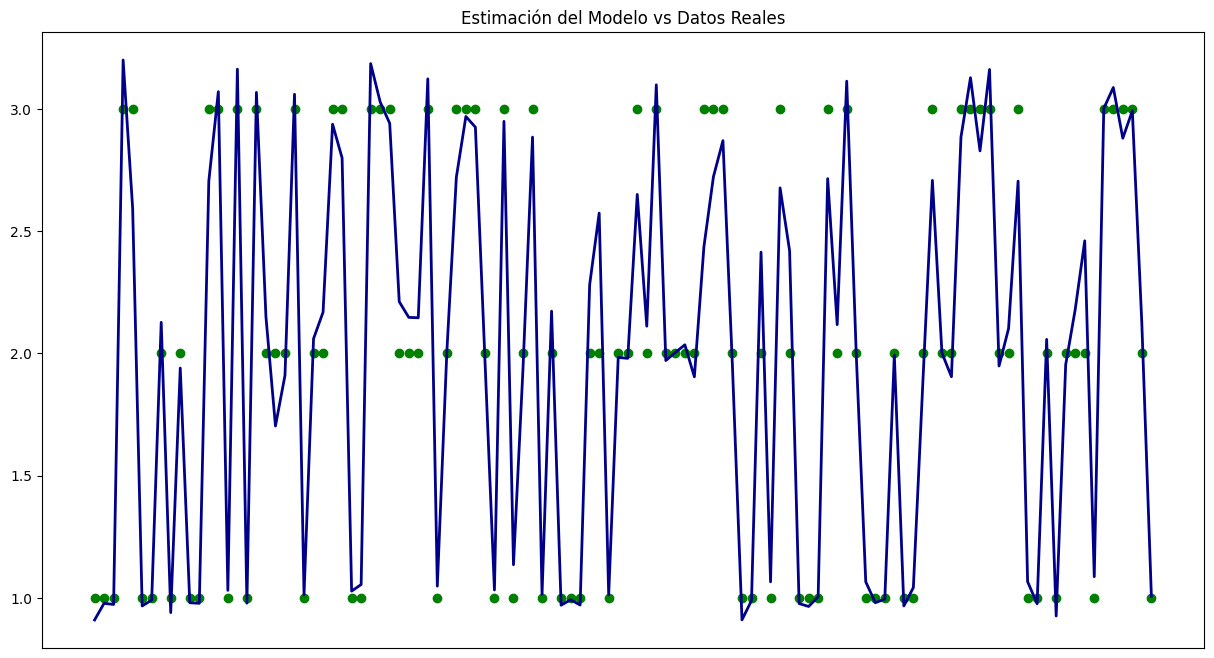

In [ ]:
#@title Mostrar Gráfico de Regresión

usar_datos = "Entrenamiento" #@param ["Entrenamiento", "Prueba"]

if usar_datos == "Entrenamiento":
  x = x_train
  y = y_train
else:
  x = x_test
  y = y_test

xEls = range(len(y)) ## x[:,0]

# muestra el árbol
plt.figure(figsize=(15,8))

yModel = model.predict(x)

# Plot outputs
plt.scatter(xEls, y, color="green")
plt.plot(xEls, yModel, color="darkblue", linewidth=2)
plt.title("Estimación del Modelo vs Datos Reales")
plt.xticks(())
#plt.yticks(())

plt.show()


*** Resultados con datos de Entrenamiento: 



 Error Absoluto: 
            Mínimo: 0.0019 
            Promedio: 0.1118 ± 0.1205
            Máximo: 0.5740 


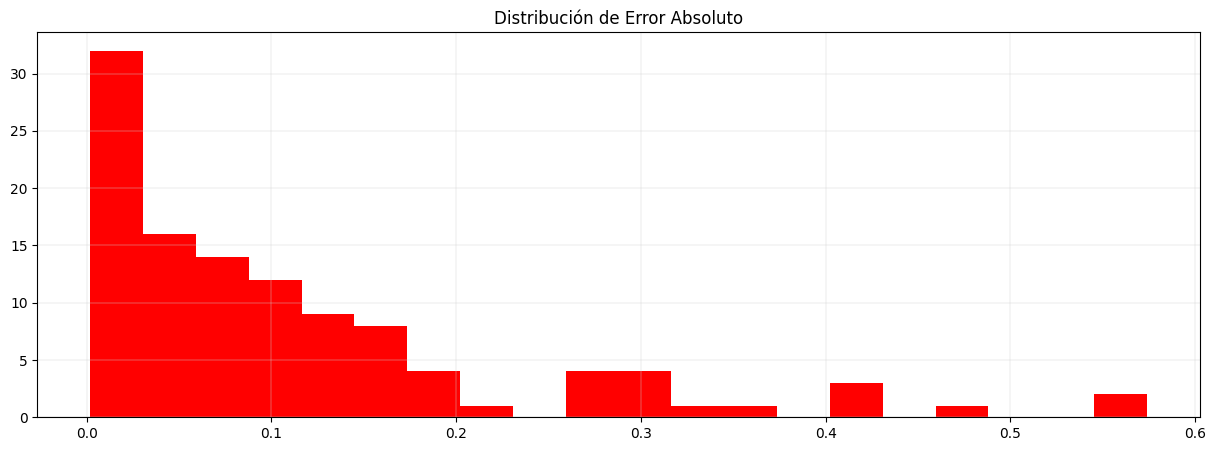


 Error Relativo: 
            Mínimo: 0.07% 
            Promedio: 5.32 ± 5.06
            Máximo: 28.70% 


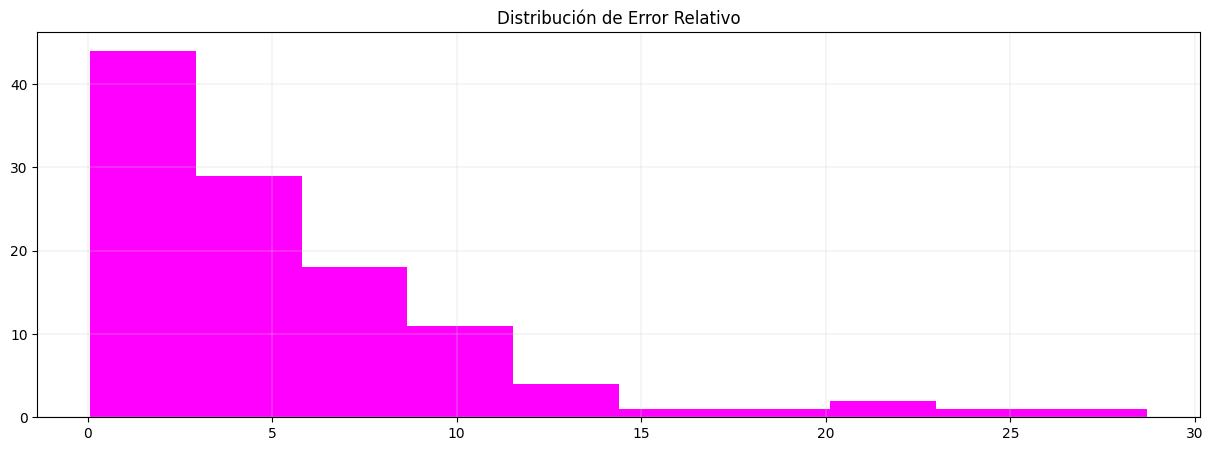

In [ ]:
#@title Evaluar red entrenada con datos de entrenamiento

umbral_clasificacion = 50 # param {type:"slider", min:1, max:99, step:1}
mostrar_detalle_entrenamiento = False #@param {type:"boolean"}
incluirDatosEntrada_detalle_entrenamiento = False #@param {type:"boolean"}


# función auxiliar para el cálculo de error
def calcErrores(datos, pred, real, mostrarDetalle=False, inclDatosEntrada=False):
  arAbs = []
  arRel = []

  if mostrarDetalle:
    if inclDatosEntrada:
      print(" Datos ->", end="")
    print(" Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]")

  for x, pV, r in zip(datos, pred, real):
    # toma el valor estimado/predecido
    p = pV
    # controla que sean números
    if not(math.isnan(r) or math.isnan(p)):
      # hace los cálculos
      eAbs = abs(r - p)
      if r != 0:
        eRel = (eAbs / r)*100.0
      else:
        eRel = (eAbs / 0.00001)*100.0
      arAbs.append(eAbs)
      arRel.append(eRel)

      if mostrarDetalle:
        if inclDatosEntrada:
          print(" " + str(x) + "->", end="")
        print(" R: {:>8.4f} / M: {:>8.4f} [ {:>8.4f} | {:>8.2f}% ]".format(r, p, eAbs, eRel))

  return arAbs, arRel

def generarGrafico(ar, tit, b=10, c=None):
     # genera gráfico de los errores
    fig = plt.figure(figsize=(15,5))
    plt.hist( ar, bins=b, color=c )
    plt.grid(color='lightgrey', which='both', axis='both', linestyle='solid', linewidth=0.3)
    plt.title("Distribución de "+ tit)
    plt.show()


# función auxiliar para probar el modelo entrenado en detalle
def probarModelo_Estimacion(x, y, detalle=False, inclDatosEntrada=False):

    # procesa las imágenes de prueba con el modelo
    estimVals = model.predict(x)

    # llama a la función
    arAbs, arRel = calcErrores(x, estimVals, y, detalle, inclDatosEntrada)

    # muestra métricas
    print("\n")
    print("\n Error Absoluto: ")
    print("            Mínimo: {:.4f} ".format(np.min(arAbs)) )
    print("            Promedio: {:.4f} ± {:.4f}".format(np.mean(arAbs), np.std(arAbs)) )
    print("            Máximo: {:.4f} ".format(np.max(arAbs)) )
    generarGrafico(arAbs, "Error Absoluto", 20, "red")

    print("\n Error Relativo: ")
    print("            Mínimo: {:.2f}% ".format(np.min(arRel)) )
    print("            Promedio: {:.2f} ± {:.2f}".format(np.mean(arRel), np.std(arRel)) )
    print("            Máximo: {:.2f}% ".format(np.max(arRel)) )
    generarGrafico(arRel, "Error Relativo", 10, "magenta")


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo_Estimacion(x_train, y_train, mostrar_detalle_entrenamiento, incluirDatosEntrada_detalle_entrenamiento)




*** Resultados con datos de Prueba: 
 Valor Real / Valor Modelo [ Error Absoluto | Error Relativo ]
 R:   2.0000 / M:   1.9757 [   0.0243 |     1.21% ]
 R:   1.0000 / M:   0.9916 [   0.0084 |     0.84% ]
 R:   1.0000 / M:   1.0655 [   0.0655 |     6.55% ]
 R:   3.0000 / M:   2.8466 [   0.1534 |     5.11% ]
 R:   1.0000 / M:   0.9944 [   0.0056 |     0.56% ]
 R:   3.0000 / M:   2.5985 [   0.4015 |    13.38% ]
 R:   1.0000 / M:   1.0070 [   0.0070 |     0.70% ]
 R:   2.0000 / M:   1.9977 [   0.0023 |     0.11% ]
 R:   2.0000 / M:   1.8115 [   0.1885 |     9.43% ]
 R:   3.0000 / M:   2.8230 [   0.1770 |     5.90% ]
 R:   3.0000 / M:   2.6499 [   0.3501 |    11.67% ]
 R:   1.0000 / M:   0.9991 [   0.0009 |     0.09% ]
 R:   3.0000 / M:   2.8336 [   0.1664 |     5.55% ]
 R:   1.0000 / M:   1.1139 [   0.1139 |    11.39% ]
 R:   2.0000 / M:   2.2530 [   0.2530 |    12.65% ]
 R:   1.0000 / M:   1.4105 [   0.4105 |    41.05% ]
 R:   1.0000 / M:   1.0475 [   0.0475 |     4.75% ]
 R:   2.0000 /

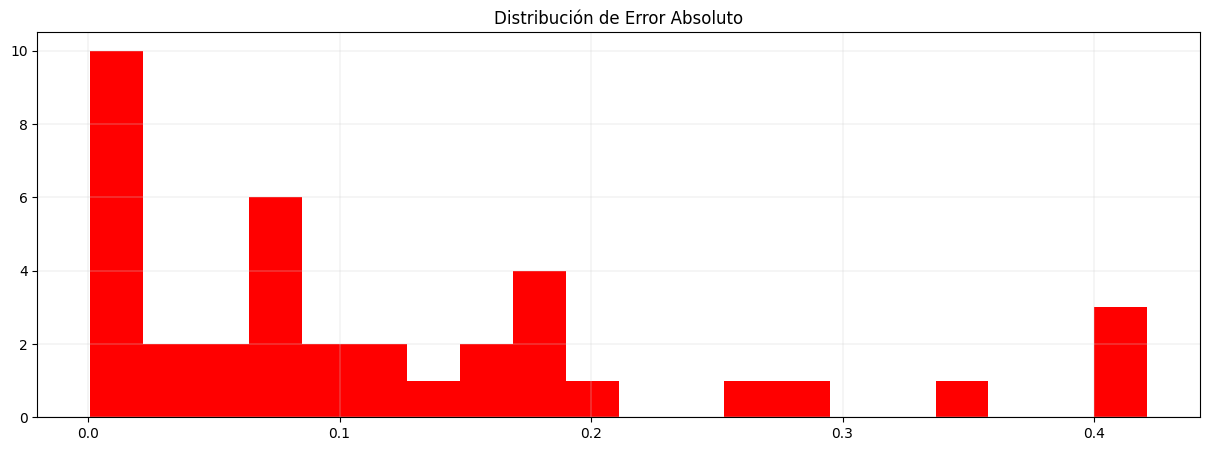


 Error Relativo: 
            Mínimo: 0.07% 
            Promedio: 6.16 ± 7.16
            Máximo: 41.05% 


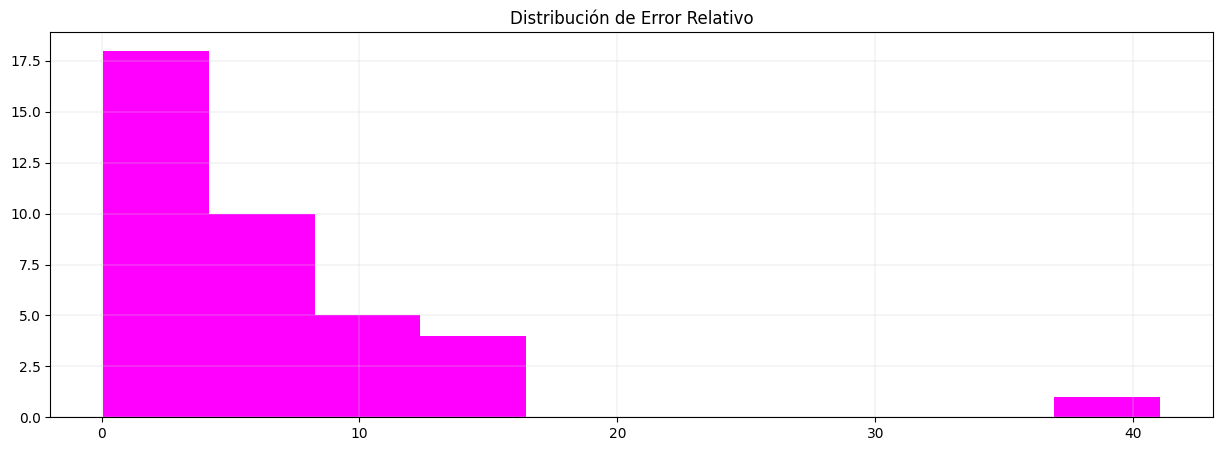

In [ ]:
#@title Evaluar red entrenada con datos de prueba
mostrar_detalle_prueba = True #@param {type:"boolean"}
incluirDatosEntrada_detalle_prueba = False #@param {type:"boolean"}

# prueba con los datos de prueba
print("\n\n*** Resultados con datos de Prueba: ")
probarModelo_Estimacion(x_test, y_test, mostrar_detalle_prueba, incluirDatosEntrada_detalle_prueba)
